# Evaluation of associations between alpha diversity and clinical features

Author: Monica R. Ticlla Ccenhua <br>
e-mail: mticlla@gmail.com monicaroxana.ticllaccenhua@unibas.ch

**Summary**

To test associations of Faith's PD with TB disease manifestations, we used the R package _car_ v3.0 to create multi-way ANCOVA models with log transformed Faith's PD. ANCOVA models with interaction terms were selected using stepwise-selection based on the Akaike information criterion (AIC), as implemented in the function _step_ of the R package _stats_. On selected models, we tested normality of residuals, homoscedascity, non-multicolinearity, independence of errors and effect of influential observations. To assess the effect sizes of factors within selected models, we computed the partial eta squared statistic (partial $\eta^{2}$), which is the proportion of the Sum of Squares (SS) of the effect and the error that is attributable to the effect <cite data-cite="2542765/I5AZL5XT"></cite>. Post-hoc tests included t-tests on adjusted means with R package _emmeans_.

**References**

<div class="cite2c-biblio"></div>

In [1]:
report_date = %env REPORT_DATE
print(report_date)

2020-07-20


## 0. Set-up working environment

**Set-up working directory**

In [2]:
%%capture
cd ../

**Import python modules**

In [3]:
%load_ext rpy2.ipython

.Rprofile: Setting Swiss repository



**Import R packages**

In [4]:
%%capture
%%R
library(phyloseq)
library(ggplot2)
library(hrbrthemes)
hrbrthemes::import_roboto_condensed()
library(RColorBrewer)
library(grid)
library(gridExtra)
library(zCompositions)
library(factoextra)
library(vegan)
library(ggpubr)
library(ggrepel)
library("scales")
library(car)
library(emmeans)
library(simpleboot)
options("width"=200)

**Local functions**

In [5]:
%%R
## Summarizes data.
## Gives count, mean, standard deviation, standard error(se) of the mean, and confidence interval (default 95%).
## Standard error and confidence intervals are computed by stundendized boostrap method
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summarized
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
##   R: number of bootstraps to compute conf.interval
summarySE.bootstrap <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE, .R=100) {
    library(plyr)
    library(simpleboot)
    library(boot)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, sd, se, lci and uci
    datac <- plyr::ddply(data, groupvars, .drop=.drop,
                         .fun = function(xx, col) {
                             N = length2(xx[[col]], na.rm=na.rm)
                             if (N >=5) {
                                 #Studentized, bootstraped CIs
                                 bmean = one.boot(xx[[col]], mean, student=TRUE, M=round(.R/10), R=.R, 
                                                  na.rm=na.rm)
                                 bmean.ci = boot.ci(bmean,type = "stud")
                                 c(N    = length2(xx[[col]], na.rm=na.rm),
                                   mean = mean   (xx[[col]], na.rm=na.rm),
                                   sd   = sd     (xx[[col]], na.rm=na.rm),
                                   se   = sd(bmean$t[,1]),
                                   lci  = bmean.ci$student[4],
                                   uci  = bmean.ci$student[5]
                              )
                             } else {
                                 c(N    = length2(xx[[col]], na.rm=na.rm),
                                   mean = mean   (xx[[col]], na.rm=na.rm),
                                   sd   = sd     (xx[[col]], na.rm=na.rm),
                                   se   = NA,
                                   lci  = NA,
                                   uci  = NA
                              )
                                 
                             }

                         },
                         measurevar
                        )

    # Rename the "mean" column    
    datac <- plyr::rename(datac, c("mean" = measurevar))
    return(datac)
}


### 1.1 16S-AS taxonomic profiles

**Taxonomy table**

In [6]:
%%R
# Loading the taxonomy table
# --------------------------
#' Convert taxonomy table produced by QIIME2 to a 7-ranks data frame
#'
#' @param qiime2_taxonomy A data frame with columns c('Taxon', 'Confidence')
#' @return The taxonomy table as dataframe with seven columns, the seven taxonomic ranks.
qiime2taxonomy_to_df <- function(qiime2_taxonomy){
    features_ids <- rownames(qiime2_taxonomy)
    taxon_ranks_n = 7
    taxon_rank_names = c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
    taxonomies = sapply(qiime2_taxonomy$Taxon, 
                        function(x,nranks){
                            taxonomy_vector = strsplit(x,'; ')[[1]]
                            na_vector = rep(NA,nranks-length(taxonomy_vector))
                            c(taxonomy_vector,na_vector)}, 
                        taxon_ranks_n)
    taxonomies = data.frame(matrix(taxonomies, 
                                   nrow=length(features_ids), 
                                   ncol=taxon_ranks_n, byrow=TRUE), 
                            row.names=features_ids, 
                            stringsAsFactors=FALSE)
    colnames(taxonomies) <- taxon_rank_names
    return(taxonomies)
}

# Load taxonomies
asv16s_taxonomy_table_file <- './data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/exported/taxonomy.tsv'
asv16s_taxonomy_table <- read.table(asv16s_taxonomy_table_file, header=TRUE, sep='\t', stringsAsFactors=FALSE, 
                                    quote="", check.names=FALSE, row.names=1)
asv16s_taxonomy_table <- qiime2taxonomy_to_df(asv16s_taxonomy_table)
print(dim(asv16s_taxonomy_table))
print(asv16s_taxonomy_table[0:3,0:3])

cat("\nNr of ASVs: ")
cat(dim(asv16s_taxonomy_table)[1])

cat("\nNr of taxonomic levels: ")
cat(dim(asv16s_taxonomy_table)[2])

# Re-format taxonomy table for phyloseq
# Replace non-assigned taxonomy ranks(e.g p__) with NA
is_undefined_rank <- t(unlist(apply(asv16s_taxonomy_table, 1, 
                                    function(x){x %in% c("k__","p__","c__","o__","f__","g__","s__")})))
asv16s_taxonomy_table_ps <- asv16s_taxonomy_table
asv16s_taxonomy_table_ps[ is_undefined_rank ] <- NA


[1] 28284     7
                                     Kingdom           Phylum          Class
0000134bb4f9a56941dd1d0206a600d8 k__Bacteria p__Bacteroidetes c__Bacteroidia
00032a9354651fef5c866ec3f9cdca0d k__Bacteria p__Bacteroidetes c__Bacteroidia
000374910b98b14cc5724af75f294b87 k__Bacteria p__Bacteroidetes c__Bacteroidia

Nr of ASVs: 28284
Nr of taxonomic levels: 7

**Abundance table**

In [7]:
%%R
# Loading the feature table
# -------------------------
asv16s_qiime2_feature_table_file <- "./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/decontam_table.tsv"
asv16s_qiime2_feature_table <- read.table(asv16s_qiime2_feature_table_file, header=TRUE, sep='\t', 
                                          stringsAsFactors=FALSE, quote = "", check.names=FALSE, row.names=1, 
                                          comment.char="", skip=1)

print(asv16s_qiime2_feature_table[0:3,0:3])

# Create phyloseq object
# ----------------------
# Lets create the phyloseq object (feature/otu table and taxonomy tables merged)
asv16s_feature_table_ps <- phyloseq(otu_table(asv16s_qiime2_feature_table, 
                                              taxa_are_rows=TRUE), 
                                    tax_table(as.matrix(asv16s_taxonomy_table_ps)))
print(asv16s_feature_table_ps)


# Remove samples with less than 12000 total reads
asv16s_feature_table_ps <- prune_samples(sample_sums(asv16s_feature_table_ps) >=12000, 
                                         asv16s_feature_table_ps)

# remove ASV with abundance zero
asv16s_feature_table_ps = filter_taxa(asv16s_feature_table_ps, function(x){sum(x) > 0}, TRUE)

cat("\nContent of Phyloseq object: \n")
print(asv16s_feature_table_ps)

                                 A00030 A00034 A00036
0000134bb4f9a56941dd1d0206a600d8      0      0      0
00032a9354651fef5c866ec3f9cdca0d      0      0      0
000374910b98b14cc5724af75f294b87      0      0      0
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 28274 taxa and 335 samples ]
tax_table()   Taxonomy Table:    [ 28274 taxa by 7 taxonomic ranks ]

Content of Phyloseq object: 
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 27668 taxa and 307 samples ]
tax_table()   Taxonomy Table:    [ 27668 taxa by 7 taxonomic ranks ]


**Sequencing summaries**

In [8]:
%%R
asv16s_stats_file <- "./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/denoising-stats_run123.tsv"
asv16s_stats <- read.csv(asv16s_stats_file, sep="\t", header=TRUE, row.names=1)
print(head(asv16s_stats))
cat("\nNr of samples: ")
cat(dim(asv16s_stats)[1])

cat("\n---\n")
cat("Total retained: \n")
cat(sum(asv16s_stats$non.chimeric))

       input filtered denoised non.chimeric perc_kept
A00030 69471    35777    33346        23903  34.40716
A00034 46103    25102    24765        19104  41.43765
A00036 59728    34850    34422        26914  45.06094
A00038 53641    29543    28367        17434  32.50126
A00053   440      121       49           49  11.13636
A00056 35483    18274    17893        15719  44.30009

Nr of samples: 335
---
Total retained: 
12384275

### 1.2 Faith's phylogenetic diversity estimation

In [9]:
%%R
faithpd_file <- "./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/rarefaction/faith-pd_12k_rarefied/faith_pd.csv"
faithpd_table <- na.omit(read.table(faithpd_file, sep=',', header=TRUE, row.names=1,
                          na.strings = c('.',' ',''))[-2])
head(faithpd_table)

       depth.12000_iter.1
A00030          26.216870
A00034           6.370249
A00036          10.413151
A00038          13.682772
A00056          17.685786
A00059          17.060311


### 1.3 Genus-level interaction network

In [10]:
%%R
asv16s_bacteria_genus.ig2_file <- "./data/processed/asv16s_genus_level_network.RDA"
load(asv16s_bacteria_genus.ig2_file)
summary(asv16s_bacteria_genus.ig2)

IGRAPH 74d48b5 UNW- 147 183 -- 
+ attr: name (v/c), label (v/c), RSD (v/n), Abundance (v/n), Phylum (v/c), weight (e/n), beta (e/n), sign (e/c)


### 1.4 Host and sample metadata

**Host's clinical data**

In [11]:
%%R
# Load samples metadata
#-----------------------
sample_medatata_file <- './data/interim/host_metadata_extended.tsv'
sample_metadata <- read.table(sample_medatata_file, sep='\t', header=TRUE, row.names=1, 
                              na.strings = c('.',' ','','NA','<NA>'))

## Define the levels of categorical variables:
delaymedtp_cat2_levels <- c('no','amoxycillin','amoxycillin+ampicillin','amoxycillin+cloxacillin',
                            'amoxycillin+ampicillin+cloxacillin','other-medications')
sample_metadata$delaymedtp_cat2 <- factor(sample_metadata$delaymedtp_cat2, levels=delaymedtp_cat2_levels)
print(summary(sample_metadata$delaymedtp_cat2), nrows=2)

delaymed_3cat_levels <- c('No','Penicillins','Other')
sample_metadata$delaymed_3cat <- factor(sample_metadata$delaymed_3cat, levels=delaymed_3cat_levels)
print(summary(sample_metadata$delaymed_3cat))

sample_metadata$smear_grading_bin <- factor(sample_metadata$smear_grading_bin, levels=c('Low','High'))
print(summary(sample_metadata$smear_grading_bin))

xraysevere.levels                 <- c("Normal", "Mild/moderate", "Severe")
sample_metadata$xraysevere        <- factor(sample_metadata$xraysevere, 
                                            levels = xraysevere.levels, ordered=TRUE)
print(summary(sample_metadata$xraysevere))

tbscore_bin.levels                <- c("Mild", "Severe")
sample_metadata$tbscore_bin       <- factor(sample_metadata$tbscore_bin, 
                                            levels = tbscore_bin.levels, ordered=TRUE)
print(summary(sample_metadata$tbscore_bin))

age.levels                        <- c("<25", "25-34", "35-44", ">44")
sample_metadata$age_cat           <- factor(sample_metadata$age_cat, levels=age.levels)
print(summary(sample_metadata$age_cat))

#sex.levels                        <- c("male","female")
sex.levels                        <- c("Male","Female")
sample_metadata$male              <- factor(sample_metadata$male, levels = sex.levels)
print(summary(sample_metadata$male))

#bmi_cat.levels                    <- c("BMI >=18.5", "BMI <18.5")
bmi_cat.levels                    <- c("Normal/Obese BMI>=18.5", "Underweight BMI<18.5")
sample_metadata$bmi_cat           <- factor(sample_metadata$bmi_cat, 
                                            levels = bmi_cat.levels)
print(summary(sample_metadata$bmi_cat))

#season.levels                     <- c("Short Rain", "Long Rain", "Dry")
season.levels                     <- c("Short Rains (Oct. - Feb.)", "Long Rains (March - May)", "Dry (June - Sept.)")
sample_metadata$season            <- factor(sample_metadata$season, levels = season.levels)
print(summary(sample_metadata$season))

# CXR lesions
cavitation.levels           <- c("Absent","Present")
sample_metadata$caviation   <- factor(sample_metadata$caviation, levels=cavitation.levels, ordered=FALSE)
print(summary(sample_metadata$caviation))

infiltration.levels           <- c("Absent","Present")
sample_metadata$filtration   <- factor(sample_metadata$filtration, levels=infiltration.levels, ordered=FALSE)
print(summary(sample_metadata$filtration))

effusion.levels           <- c("Absent","Present")
sample_metadata$effusion   <- factor(sample_metadata$effusion, levels=effusion.levels, ordered=FALSE)
print(summary(sample_metadata$effusion))

lymphnode.levels           <- c("Absent","Present")
sample_metadata$lymphnode   <- factor(sample_metadata$lymphnode, levels=lymphnode.levels, ordered=FALSE)
print(summary(sample_metadata$lymphnode))

micronode.levels           <- c("Absent","Present")
sample_metadata$micronode   <- factor(sample_metadata$micronode, levels=micronode.levels, ordered=FALSE)
print(summary(sample_metadata$micronode))

anemia_levels <- c('No anemia','Mild','Moderate','Severe')
sample_metadata$anemia_status <- factor(sample_metadata$anemia_status, levels=anemia_levels, ordered=TRUE)
print(summary(sample_metadata$anemia_status))

sample_metadata$anemia_bin <- factor(sample_metadata$anemia_bin, levels=c("No","Yes"))
print(summary(sample_metadata$anemia_bin))

nutritional_status_levels <- c('Normal weight','Underweight','Obesity')
sample_metadata$nutrition_status <- factor(sample_metadata$nutrition_status, levels=nutritional_status_levels, 
                                           ordered=FALSE)
print(summary(sample_metadata$nutrition_status))

sample_metadata$xray_findings <- factor(sample_metadata$xray_findings, levels=c("Normal","Abnormal"))
print(summary(sample_metadata$xray_findings))

#cxr_categories_levels <- c("Normal","filtration","filtration_cavitation","filtration_other","effusion","other")
cxr_categories_levels <- c("Normal","Infiltration","Infiltration & Cavitation","Infiltration (other)","Pleural effusion","Other")
sample_metadata$cxr_categories <- factor(sample_metadata$cxr_categories, levels=cxr_categories_levels)
print(summary(sample_metadata$cxr_categories))

sample_metadata$lineage134 <- factor(sample_metadata$lineage134, levels=c('L3','L1','L4'))
print(summary(sample_metadata$lineage134))

cat("\n Number of samples in dataset: ")
cat(dim(sample_metadata)[1])
cat("\n Number of variables in dataset: ")
cat(dim(sample_metadata)[2])

                                no                        amoxycillin             amoxycillin+ampicillin            amoxycillin+cloxacillin amoxycillin+ampicillin+cloxacillin 
                                20                                 31                                 90                                 47                                 96 
                 other-medications 
                                50 
         No Penicillins       Other 
         20         264          50 
 Low High 
 127  207 
       Normal Mild/moderate        Severe          NA's 
           59           132            56            87 
  Mild Severe 
   223    111 
  <25 25-34 35-44   >44 
   61   129    95    49 
  Male Female 
   240     94 
Normal/Obese BMI>=18.5   Underweight BMI<18.5 
                   158                    176 
Short Rains (Oct. - Feb.)  Long Rains (March - May)        Dry (June - Sept.)                      NA's 
                      120                        74      

In [12]:
%%R
# 
sample_metadata$islineage3 <- sample_metadata$lineage
sample_metadata$islineage3 <- plyr::mapvalues(sample_metadata$islineage3, 
                                              from=c("L1","L2","L3","L4"), 
                                              to=c("Non-L3","Non-L3","L3","Non-L3")
                                             )
summary(sample_metadata$islineage3)

Non-L3     L3   NA's 
   123    102    109 


**Table with mapping IDs**

In [13]:
%%R
asv16s_mapping_ids_file <- "./data/raw/tz_spt_cases/sample_ids_mapping.txt"
wms_mapping_ids_file <- "data/raw/wms/wms_cases/sample_ids_mapping.txt"

asv16s_mapping_ids <- read.table(asv16s_mapping_ids_file, header=TRUE, sep='\t',
                                 stringsAsFactors=FALSE, row.names=1)
wms_mapping_ids <- read.table(wms_mapping_ids_file, header=TRUE, sep='\t',
                                 stringsAsFactors=FALSE, row.names=1, na.strings = c("NA",""))

print(head(asv16s_mapping_ids, n=3))
print(head(wms_mapping_ids, n=3))

       SpecimenID SubjectID seq_run
A00030     S00394    H00388    run1
A00034     S00426    H00421    run1
A00036     S00173    H00173    run1
       SpecimenID SubjectID
M00001     S00181    H00183
M00002     S00375    H00368
M00004        NC3      <NA>


## 2. Test normality of Faith's phylogenetic diversity

In [14]:
%%R
print(shapiro.test(faithpd_table[,1]))


	Shapiro-Wilk normality test

data:  faithpd_table[, 1]
W = 0.92664, p-value = 3.799e-11



The null hypothesis of the Shapiro-Wilk normality test is that "Faith's phylogenetic diversity is normally distributed". Since the p-value is below a significance level (0.05), we reject the null hypothesis in favor of the alternative hypothesis, "Faith's phylogenetic diversity is not normally distributed". Lets check if logarithmic transformations solve the non-normality issue:

In [15]:
%%R
print(shapiro.test(log(faithpd_table[,1])))


	Shapiro-Wilk normality test

data:  log(faithpd_table[, 1])
W = 0.99313, p-value = 0.1727



The logarithm transformation solved the non-normality issue. From now on, any test on Faith's phylogenetic diversity will be preceded by a logarithmic transformation.

## 3. Testing associations with Faith's phylogenetic diversity

We are interested in finding out if variation of Faith's phylogenetic diversity is associated with three clinical phenotypes: Mycobacterial load (inferred from Acid-Fast Bacilli(AFB) smear grading), lung damage (inferred from chest x-rays), and disease severity(inferred from a clinical score, specific for TB). In this dataset, these three variables were not associated with each other; TB cases with worst symptoms and signs (TB score) won't necessarily have more mycobacterial load in their lungs or chest x-ray signs of lung damage, and lung damage does not imply more mycobacterial load in the lungs. However, lung damage is negatively associated with HIV status; 50 % of TB cases with no x-ray signs of lung damage were co-infected with HIV, while only 20 % of TB cases with x-ray signs of lung damage were co-infected with HIV. 

Therefore we tested the association of alpha diversity with lung damage and mycobacterial load in the same model. These associations were tested while considering age, sex, BMI, hemoglobin levels, HIV, viral/bacterial respiratory infections, helminths, smoking, alcoholism, season, self-medication, delay in diagnosis.

The marginal effect of clinical severity (as assessed by a TB score) was tested with a second model, while adjusting for delay in diagnosis, and the covariates included in the first model; except for BMI and anemia which are parameters used to compute the TB score.

### 3.1 Create dataframe with variables to be included in ANCOVA model(s)

In [16]:
%%R
clinical_metadata_vars <- c('xray_findings','cxr_categories','tbscore_bin','smear_grading_bin', 'islineage3','lineage134', 
                           'tbdelay','delaymed', 'delaymed_3cat', 'male', 'age_cat', 'bmi_cat', 'anemia_bin',
                           'hiv', 'viral', 'helminth', 'bacterial', 'smoking', 'alcoholabuse', 'season',
                            'filtration','caviation','micronode','effusion','lymphnode')

clinical_metadata_table <- asv16s_mapping_ids[sample_names(asv16s_feature_table_ps),]
clinical_metadata_table <- cbind(clinical_metadata_table, 
                                 sample_metadata[clinical_metadata_table$SubjectID,clinical_metadata_vars])
# Add sequencing depth
clinical_metadata_table$seq_depth <- asv16s_stats[rownames(clinical_metadata_table), "input"]
clinical_metadata_table$seq_depth_sc <- scale(clinical_metadata_table$seq_depth)
# Add Phylogenetic diversity
clinical_metadata_table$faithpd <- faithpd_table[rownames(clinical_metadata_table),]

### 3.2 ANCOVA model to simultaneously assess the marginal effects of abnormal CXR-findings and high mycobacterial load in sputum on Faith's phylogenetic diversity

**Helper functions**

In [17]:
%%R
# This function performs step-forward selection of terms
my_model_selector <- function(null_model, min_model, max_model){
    cat(crayon::bold("\nStep-Forward addition of interaction terms:\n"))
    fwd_aic_selected <- step(min_model, direction='forward', scope=formula(max_model), 
                             k=log(dim(min_model$model)[1]))
    
    # is the model without interactions better than the null model?
    cat(crayon::bold("\nIs the model without interactions better than a null model?\n"))
    print(anova(null_model,min_model))
    
    # is the model with interactions better than the model without interactions?
    cat(crayon::bold("\nIs the model with interactions better than the one with interactions?\n"))
    print(anova(min_model,fwd_aic_selected))
    
    # How much variance is explained by the models?
    cat(crayon::bold("\nHow much variance is explained by the model without interactions?\n"))
    cat("Adjusted R-squared: ")
    cat(summary(min_model)$adj.r.squared)
    
    cat(crayon::bold("\nHow much variance is explained by the model with interactions?\n"))
    cat("Adjusted R-squared: ")
    cat(summary(fwd_aic_selected)$adj.r.squared)
    
    return(fwd_aic_selected)
}

# Adapted from http://www.understandingdata.net/2017/05/11/anova-tables-in-r/
# Calculates the partial eta-squared as a measure of effect size of each term in an Anova model
# anova.obj: output from function Anova in the car package
Anova.effectsize <- function(anova.obj){
    anova.obj$pes <- c(anova.obj$'Sum Sq'[-nrow(anova.obj)], NA)/(anova.obj$'Sum Sq' + 
                                                                  anova.obj$'Sum Sq'[nrow(anova.obj)])
    return(anova.obj)
}

Anova.manyfactors <- function(response, vars, data, contrasts, type=3){
    y.data = response
    x.data = data[vars]

    if (length(vars)==1){
        vars.lmfit = lm(y.data ~ ., data=x.data, contrasts=contrasts)
        results.anova <- Anova(vars.lmfit, type=type)
        results.anova <- Anova.effectsize(results.anova)
    } else if (length(vars)>1){
        results.anova <- sapply(vars, function(var){var.lmfit = lm(y.data ~ ., data=x.data[var], 
                                                                   contrasts=contrasts)
                                                    result.anova <- Anova(var.lmfit, type=type)
                                                    result.anova <- Anova.effectsize(result.anova)
                                                    result.anova[2,]}, simplify=FALSE)

        row.labels <- names(results.anova)
        results.anova <- dplyr::bind_rows(results.anova)
        rownames(results.anova) <- row.labels
    }
    
    return(results.anova)   
}

# Adapted from http://www.understandingdata.net/2017/05/11/anova-tables-in-r/
# Calculates the partial eta-squared as a measure of effect size of each term in an Anova model
# anova.obj: output from function Anova in the car package
Anova.combined <- function(response, vars, inter.formula=NULL, data, contrasts, type=3){
    y.data = response
    x.data = data[vars]
    
    if (is.null(inter.formula)){
        vars.lmfit = lm(y.data ~ ., data=x.data, contrasts=contrasts)
    } else if (!is.null(inter.formula)){
        my.formula <- as.formula(paste("y.data ~ .", inter.formula, sep=" + "))
        print(my.formula)
        vars.lmfit = lm(my.formula, data=x.data, contrasts=contrasts)
    }

    multi.anova <- Anova(vars.lmfit, type=type)
    multi.anova <- Anova.effectsize(multi.anova)
    
    many.uni.anova <- Anova.manyfactors(y.data, vars=vars, data=x.data, contrasts=contrasts, type=type)[,c(4,5)]
    
    row.labels = c('(Intercept)', rownames(many.uni.anova))
    colnames(many.uni.anova) <- paste0(colnames(many.uni.anova),'.uni')
    rownames(multi.anova)[1:length(row.labels)] <- row.labels
    output.row.labels <- rownames(multi.anova)
    
    output <- merge(multi.anova,many.uni.anova, by=0, all=T)
    rownames(output) <- output$Row.names
    #output$Row.names <- NULL
    return(output[output.row.labels,])
}

**Model selection**

In [18]:
%%R
model_contrasts <- list(tbscore_bin='contr.sum', cxr_categories='contr.sum', xray_findings='contr.sum',
                        islineage3='contr.sum',lineage134='contr.sum',smear_grading_bin='contr.sum', tbdelay='contr.sum', 
                        male='contr.sum', age_cat='contr.sum', bmi_cat='contr.sum', anemia_bin='contr.sum', 
                        hiv='contr.sum', viral='contr.sum', bacterial='contr.sum', helminth='contr.sum', 
                        smoking='contr.sum', alcoholabuse='contr.sum', delaymed_3cat='contr.sum', 
                        season='contr.sum', seq_run='contr.sum')

# Model without interactions
model1_Faith_fit_nointer <- lm(log(faithpd) ~ xray_findings + smear_grading_bin + tbdelay + 
                               male + age_cat + bmi_cat + anemia_bin + 
                               hiv + viral + bacterial + helminth + smoking + alcoholabuse + 
                               delaymed_3cat + season + seq_depth_sc + seq_run, 
                               data=clinical_metadata_table, 
                               contrasts=model_contrasts)

# Model with interactions (full model)
model1_Faith_fit_full <-  lm(`log(faithpd)` ~ xray_findings + smear_grading_bin + tbdelay + 
                             male + age_cat + bmi_cat + anemia_bin + 
                             hiv + viral + bacterial + helminth + smoking + alcoholabuse + 
                             delaymed_3cat + season + seq_depth_sc + seq_run + 
                             xray_findings*tbdelay +
                             xray_findings*male + 
                             xray_findings*age_cat + 
                             xray_findings*bmi_cat + 
                             xray_findings*anemia_bin + 
                             xray_findings*hiv +
                             xray_findings*viral + 
                             xray_findings*bacterial + 
                             xray_findings*helminth + 
                             xray_findings*smoking + 
                             xray_findings*alcoholabuse + 
                             xray_findings*season +
                             smear_grading_bin*tbdelay +
                             smear_grading_bin*male + 
                             smear_grading_bin*age_cat + 
                             smear_grading_bin*bmi_cat + 
                             smear_grading_bin*anemia_bin + 
                             smear_grading_bin*hiv + 
                             smear_grading_bin*viral + 
                             smear_grading_bin*bacterial + 
                             smear_grading_bin*helminth + 
                             smear_grading_bin*smoking + 
                             smear_grading_bin*alcoholabuse + 
                             smear_grading_bin*season , 
                             data=model1_Faith_fit_nointer$model, 
                             contrasts=model_contrasts)

model1_Faith_fit_null <- lm(`log(faithpd)` ~ 1, data=model1_Faith_fit_nointer$model, 
                            contrasts=model_contrasts)

# Step forward selection of interaction terms
model1_Faith_fwd_aic_selected <- my_model_selector(model1_Faith_fit_null, model1_Faith_fit_nointer, 
                                                   model1_Faith_fit_full)

#print(Anova(nonhiv_Faith_fit_nointer, type=2))
print(car::Anova(model1_Faith_fwd_aic_selected, type=3))


Step-Forward addition of interaction terms:
Start:  AIC=-230.95
log(faithpd) ~ xray_findings + smear_grading_bin + tbdelay + 
    male + age_cat + bmi_cat + anemia_bin + hiv + viral + bacterial + 
    helminth + smoking + alcoholabuse + delaymed_3cat + season + 
    seq_depth_sc + seq_run

                                 Df Sum of Sq    RSS     AIC
+ xray_findings:bmi_cat           1   1.12432 15.404 -236.82
<none>                                        16.528 -230.95
+ xray_findings:viral             1   0.37169 16.157 -229.43
+ smear_grading_bin:smoking       1   0.27374 16.255 -228.49
+ xray_findings:anemia_bin        1   0.20302 16.325 -227.82
+ smear_grading_bin:bmi_cat       1   0.14802 16.380 -227.30
+ smear_grading_bin:anemia_bin    1   0.09970 16.428 -226.84
+ xray_findings:smoking           1   0.08692 16.441 -226.72
+ smear_grading_bin:tbdelay       1   0.07048 16.458 -226.56
+ xray_findings:alcoholabuse      1   0.04372 16.485 -226.31
+ smear_grading_bin:viral         1  

**Diagnostics of selected model**


Homoscedascity test
Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.008689384, Df = 1, p = 0.92573

Multicolinearity test
                          GVIF Df GVIF^(1/(2*Df))
xray_findings         1.268935  1        1.126470
smear_grading_bin     1.349678  1        1.161756
tbdelay               1.264211  1        1.124371
male                  1.253889  1        1.119772
age_cat               1.757961  3        1.098588
bmi_cat               1.638822  1        1.280165
anemia_bin            1.218338  1        1.103784
hiv                   1.540853  1        1.241311
viral                 1.253127  1        1.119432
bacterial             1.150899  1        1.072800
helminth              1.238370  1        1.112821
smoking               1.450714  1        1.204456
alcoholabuse          1.418818  1        1.191142
delaymed_3cat         1.418231  2        1.091281
season                2.470144  2        1.253662
seq_depth_sc          2.529110  1        1

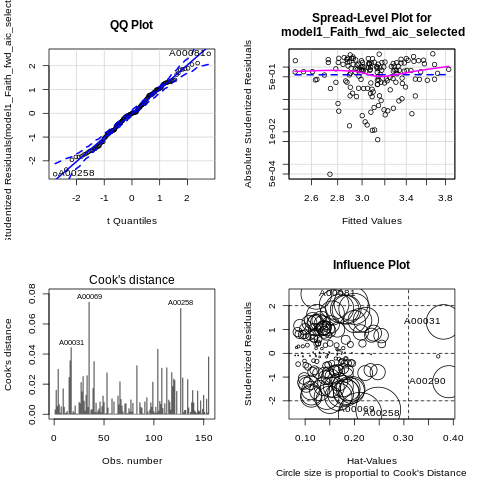

In [19]:
%%R
library(car)
par(mfrow=c(2,2))

# Normality of residuals
#------------------------
qqPlot(model1_Faith_fwd_aic_selected, main= "QQ Plot")

# Homoscedascity
#------------------------
# Score Test for Non-Constant Error Variance
# null hypothesis : constant error variance
# alternative hypothesis: the error variance changes with the level of the response (fitted values)
cat(crayon::bold("\nHomoscedascity test\n"))
print(ncvTest(model1_Faith_fwd_aic_selected))

# Plot studentized residuals vs. fitted values
spreadLevelPlot(model1_Faith_fwd_aic_selected, robust.line=TRUE)

# Non-Multicolinearity
#--------------------------
cat(crayon::bold("\nMulticolinearity test\n"))
# Generalized variance-inflation factors (GVIF)
# GVIF^(1/(2*Df)) : GVIF adjusted for the dimension of the confidence ellipsoid
# where df is the degrees of freedom associated with the term
print(car::vif(model1_Faith_fwd_aic_selected))

# Independence of errors
#--------------------------
cat(crayon::bold("\nDurbin-Watson Test for Autocorrelated Errors\n"))
# Durbin-Watson Test for Autocorrelated Errors
# null hypothesis: no autocorrelation of errors
# alternative hypothesis: autocorrelation of errors
print(durbinWatsonTest(model1_Faith_fwd_aic_selected))

# Influential observations
#----------------------------
cat(crayon::bold("\nInfluential observations\n"))
# Cook's D plot
# identify D values > 4/(n-k-1)
Faith_cooks_cutoff <- 4/((nrow(model1_Faith_fwd_aic_selected$model)-length(model1_Faith_fwd_aic_selected$coefficients)-2))
plot(model1_Faith_fwd_aic_selected, which=4, cook.levels=Faith_cooks_cutoff)

# Influence plot 
Faith_influencers <- influencePlot(model1_Faith_fwd_aic_selected, id.method="identify", 
                                   main="Influence Plot", 
                                   sub="Circle size is proportial to Cook's Distance" )
print(row.names(Faith_influencers))

# Effect of removing influential observations
# -------------------------------------------
cat(crayon::bold("\nEffect of influential observations"))
# Vector flagging influential observations
is_influencer <- (row.names(model1_Faith_fwd_aic_selected$model) %in% row.names(Faith_influencers))
# Re-fit model after removing influential observations
model1_Faith_fwd_aic_selected_updated <- update(model1_Faith_fwd_aic_selected, subset=!is_influencer)

cat("\nAdjusted R-squared of model (with influential observations): ")
cat(summary(model1_Faith_fwd_aic_selected)$adj.r.squared)
cat("\nP-value of model: ")
cat(pf(summary(model1_Faith_fwd_aic_selected)$fstatistic[1], 
       summary(model1_Faith_fwd_aic_selected)$fstatistic[2], 
       summary(model1_Faith_fwd_aic_selected)$fstatistic[3], 
       lower.tail = FALSE)[1])
cat("\nAdjusted R-squared of model (removed influential observations): ")
cat(summary(model1_Faith_fwd_aic_selected_updated)$adj.r.squared)
cat("\nP-value of updated model: ")
cat(pf(summary(model1_Faith_fwd_aic_selected_updated)$fstatistic[1], 
       summary(model1_Faith_fwd_aic_selected_updated)$fstatistic[2], 
       summary(model1_Faith_fwd_aic_selected_updated)$fstatistic[3], 
       lower.tail = FALSE)[1])

**Effect sizes of factors within model**

Lets re-compute the Ancova on the selected model, together with the effect sizes of each factor in the model. To measure the size of the effect for a factor, we calculate the partial Eta squared (\[h_p\]) which is the proportion of the factor's effect + error variance that is attributable to the effect.

In [20]:
%%R
model1_Faith_covars <- c('xray_findings','smear_grading_bin','tbdelay', 'male','age_cat',
                         'bmi_cat','anemia_bin','hiv','viral','bacterial','helminth','smoking',
                         'alcoholabuse','delaymed_3cat','season','seq_depth_sc','seq_run')
model1_Faith_interactions <- c("xray_findings*bmi_cat")

model1_Faith_w_pes <- Anova.combined(response=log(clinical_metadata_table[rownames(model1_Faith_fwd_aic_selected$model),
                                                                           'faithpd']),
                                     vars=model1_Faith_covars,
                                     inter.formula=model1_Faith_interactions,
                                     data=model1_Faith_fwd_aic_selected$model[model1_Faith_covars], 
                                     contrasts=model_contrasts, type=3)
model1_Faith_w_pes

y.data ~ . + xray_findings * bmi_cat
<environment: 0x55fbfafe83c8>
                                  Row.names       Sum Sq  Df      F value       Pr(>F)          pes   Pr(>F).uni      pes.uni
(Intercept)                     (Intercept) 78.206458449   1 665.09313929 3.540064e-53 0.8354463900           NA           NA
xray_findings                 xray_findings  0.447269619   1   3.80372620 5.327410e-02 0.0282167734 1.981239e-01 0.0108011565
smear_grading_bin         smear_grading_bin  0.045271764   1   0.38500579 5.360143e-01 0.0029303632 8.594149e-01 0.0002056900
tbdelay                             tbdelay  0.002221571   1   0.01889296 8.908848e-01 0.0001442003 9.199293e-01 0.0000662586
male                                   male  0.008155325   1   0.06935553 7.926912e-01 0.0005291514 7.808469e-01 0.0005074350
age_cat                             age_cat  0.473057592   3   1.34101183 2.639001e-01 0.0297951789 4.644228e-01 0.0167604315
bmi_cat                             bmi_cat  0.2788

Lets plot the effect sizes:

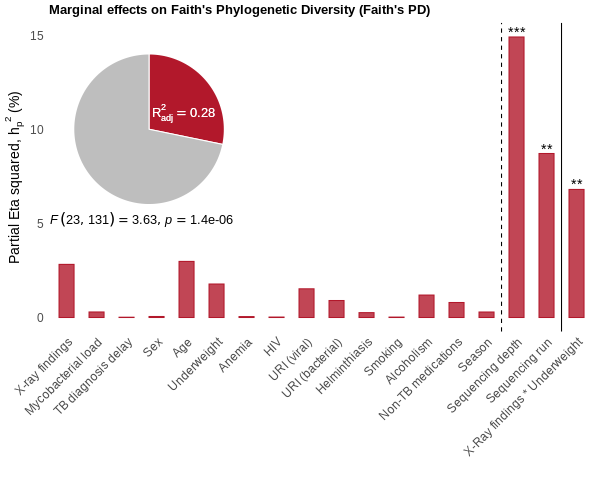

In [21]:
%%R -w 600

model1_Faith_w_pes_toplot <- model1_Faith_w_pes[2:(dim(model1_Faith_w_pes)[1]-1),]
model1_Faith_w_pes_toplot$Row.names <- factor(model1_Faith_w_pes_toplot$Row.names, 
                                              levels=c(model1_Faith_covars,
                                                       'xray_findings:bmi_cat'))
var_labels <- c('xray_findings'='X-ray findings',
                'smear_grading_bin'='Mycobacterial load',
                'tbdelay'='TB diagnosis delay',
                'male'='Sex', 
                'age_cat'='Age',
                'bmi_cat'='Underweight', 
                'anemia_bin'='Anemia', 
                'hiv'='HIV',
                'viral'='URI (viral)', 
                'bacterial'='URI (bacterial)', 
                'helminth'='Helminthiasis', 
                'smoking'='Smoking',
                'alcoholabuse'='Alcoholism',
                'delaymed_3cat'='Non-TB medications',
                'season'='Season', 
                'seq_depth_sc'='Sequencing depth',
                'seq_run'='Sequencing run', 
                'xray_findings:bmi_cat'='X-Ray findings * Underweight')

signif_marks <- rep("",length(var_labels))
signif_marks[ model1_Faith_w_pes_toplot[,'Pr(>F)'] < 0.001 ] <- '***'
signif_marks[ model1_Faith_w_pes_toplot[,'Pr(>F)'] < 0.01 & model1_Faith_w_pes_toplot[,'Pr(>F)'] >= 0.001 ] <- '**'
signif_marks[ model1_Faith_w_pes_toplot[,'Pr(>F)'] < 0.05 & model1_Faith_w_pes_toplot[,'Pr(>F)'] >= 0.01 ] <- '*'

model1_Faith_pes_plot <- ggplot(model1_Faith_w_pes_toplot, aes(x=Row.names,y=pes*100)) + 
                            geom_bar(position='identity', stat='identity',
                                     fill="#b2182b", color="#b2182b", alpha=0.8, width=0.5) + 
                            theme_minimal() + 
                            theme(axis.text.x = element_text(size=12,angle=45, hjust=1), 
                                  axis.text.y = element_text(size=12),
                                  axis.title=element_text(size=14,face="bold"), 
                                  plot.title = element_text(face="bold", hjust=0,size=13),
                                  panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
                            scale_x_discrete(labels=var_labels) + 
                            ggtitle("Marginal effects on Faith's Phylogenetic Diversity (Faith's PD)") + 
                            labs(x='', y=bquote('Partial Eta squared,' ~ {h[p]}^2 ~ '(%)')) + 
                            geom_text(aes(label=signif_marks), size=5, vjust=0) + 
                            geom_vline(xintercept=c(15.5,17.5), linetype = c("dashed","solid"))

model1_Faith_pie_data <- data.frame(Radj=c(summary(model1_Faith_fwd_aic_selected)$adj.r.squared, 
                                    (1-summary(model1_Faith_fwd_aic_selected)$adj.r.squared)), 
                                    group=c('Radj','FVU'))
model1_Faith_pie_label <- bquote(R[adj]^2 == .(signif(model1_Faith_pie_data$Radj[1], 2)))

model1_Faith_pie <- ggplot(model1_Faith_pie_data, aes(x="",y=Radj, fill=group)) + 
                        geom_bar(stat="identity", width=1, color="white") + 
                        coord_polar("y", start=0) +
                        scale_fill_manual(values = c("grey","#b2182b")) + 
                        theme_void() + theme(legend.position="none") + 
                        geom_text(aes(y=0.18, size=4.5,label=deparse(model1_Faith_pie_label)), 
                                  color="white", parse=TRUE)
model1_Faith_pie_grob <- ggplotGrob(model1_Faith_pie)

model1_Faith_model_fstats_label <- paste0('list(italic(F)(', summary(model1_Faith_fwd_aic_selected)$fstatistic[2], 
                                          ',', summary(model1_Faith_fwd_aic_selected)$fstatistic[3], ') == ', 
                                          signif(summary(model1_Faith_fwd_aic_selected)$fstatistic[1],3),
                                          ' , italic(p) == ',signif(pf(summary(model1_Faith_fwd_aic_selected)$fstatistic[1], 
                                                                    summary(model1_Faith_fwd_aic_selected)$fstatistic[2], 
                                                                    summary(model1_Faith_fwd_aic_selected)$fstatistic[3],
                                                                    lower.tail=FALSE), 2), ')')
model1_Faith_pes_plot_pie <- model1_Faith_pes_plot + annotate('text', x=3.5, y=5.2, size=4.5,
                                                              label=model1_Faith_model_fstats_label, parse=TRUE) + 
                                annotation_custom(grob=model1_Faith_pie_grob, xmin=0.5, xmax=7, ymin=5, ymax=15)

plot(model1_Faith_pes_plot_pie)

Lets plot the adjusted means for the significant interaction term:

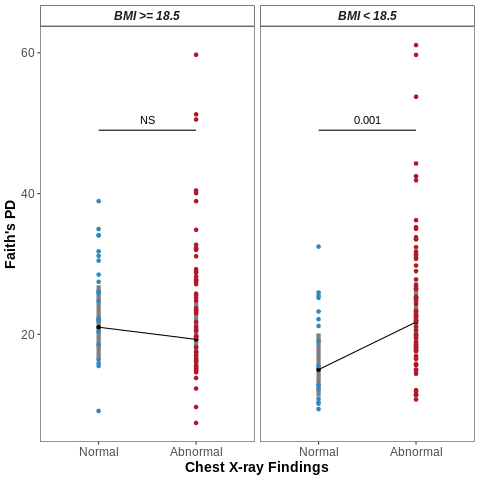

In [22]:
%%R
reformat_pval <- function(x){
    if(x<0.1){
        formatC(x, digits=3, format='f')
    }else{
        'NS'}
}
xrayfindings_colors <- c('#3288bd','#b2182b')
clinical_metadata_table$bmi_cat <- factor(clinical_metadata_table$bmi_cat, 
                                          levels = c("Normal/Obese BMI>=18.5", "Underweight BMI<18.5"), 
                                          labels = c("BMI >= 18.5", "BMI < 18.5"))

# For correct interpretation of log transformation by emmeans, we refit the model
xrayfindings_faith_lm <- lm(log(faithpd) ~ xray_findings + smear_grading_bin + 
                          tbdelay + male + age_cat + bmi_cat + anemia_bin + 
                          hiv + viral + bacterial + helminth + smoking + alcoholabuse + delaymed_3cat + 
                          season + seq_depth_sc + seq_run + xray_findings*bmi_cat, 
                          data = clinical_metadata_table, 
                          contrasts = model_contrasts)

# Estimated differene in PD means among levels of Chest X-ray findings, within BMI categories
xrayfindings_faith_bmi_contrasts_df <- as.data.frame(pairs(emmeans(xrayfindings_faith_lm, ~ xray_findings | bmi_cat)))
xrayfindings_faith_bmi_contrasts_df$x_start <- c(1,1)
xrayfindings_faith_bmi_contrasts_df$x_end <- c(2,2)
xrayfindings_faith_bmi_contrasts_df$y_end <- c(50,50)
xrayfindings_faith_bmi_contrasts_df$p_reformat <- sapply(xrayfindings_faith_bmi_contrasts_df$p.value,reformat_pval)
xrayfindings_faith_bmi_plot <- emmip(xrayfindings_faith_lm, ~ xray_findings | bmi_cat, CIs=TRUE, 
                                     type = "response") +  facet_wrap(~ bmi_cat, scales="free_x") +
                                 geom_point(aes(x=xray_findings, y=exp(`log(faithpd)`), color=xray_findings), 
                                            data=xrayfindings_faith_lm$model) + 
                                 scale_color_manual(values=xrayfindings_colors) +
                                 geom_text(aes(x=(x_start+x_end)/2, y=y_end+0.5,label=p_reformat), 
                                           data=xrayfindings_faith_bmi_contrasts_df) +
                                 geom_segment(aes(x=x_start, xend=x_end, y=y_end-1, yend=y_end-1), 
                                              data=xrayfindings_faith_bmi_contrasts_df) + 
                                 labs(y="Faith's PD", 
                                      x="Chest X-ray Findings") + 
                                 theme_bw() + 
                                 theme(axis.text.x = element_text(size=12), 
                                       axis.text.y = element_text(size=12),
                                       axis.title=element_text(size=14,face="bold"), 
                                       strip.text.x = element_text(size = 12, face = "bold.italic"),
                                       strip.background = element_rect(colour="black", fill="white"),
                                       legend.position="none", 
                                       panel.grid.major = element_blank(), 
                                       panel.grid.minor = element_blank())

plot(xrayfindings_faith_bmi_plot)

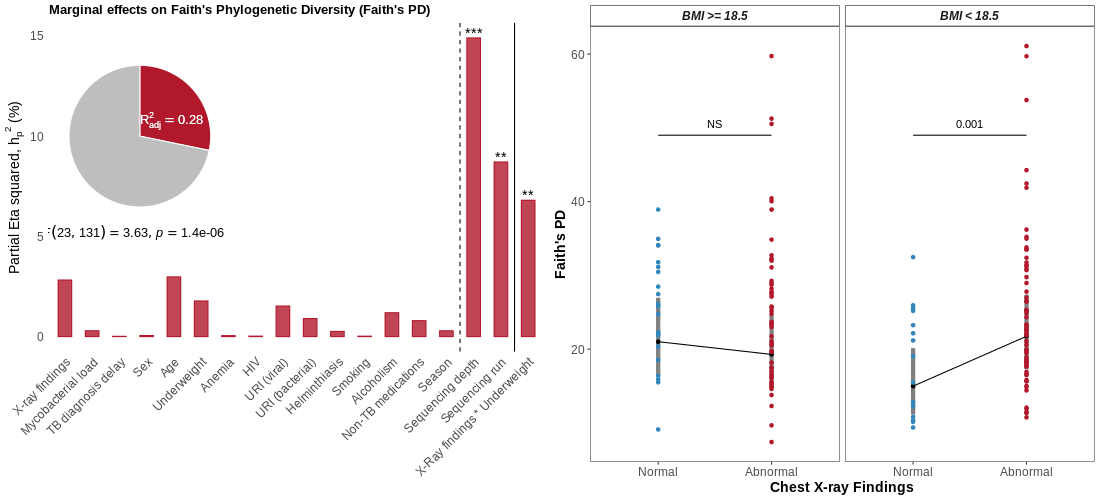

In [23]:
%%R -w 1100 -h 500

grid.arrange(grobs=list(model1_Faith_pes_plot_pie, xrayfindings_faith_bmi_plot), nrow=1, width=c(0.6,0.4))

### 3.3 Faith's PD by types of CXR findings

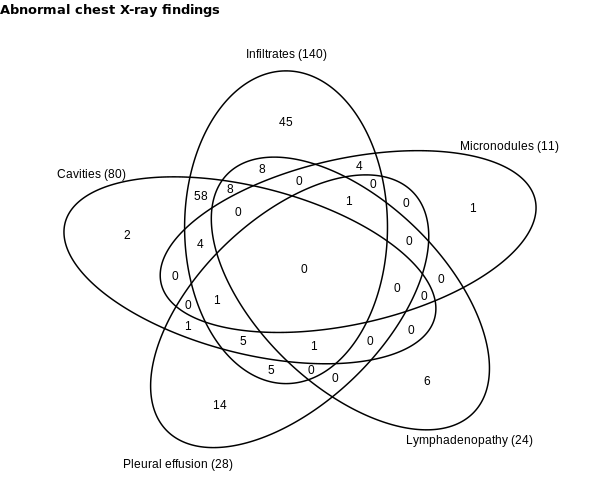

In [24]:
%%R -w 600 -h 500 -u px
library(ggplotify)
set_infiltration <- unique(rownames(subset(clinical_metadata_table, filtration=='Present')))
set_cavitation <- unique(rownames(subset(clinical_metadata_table, caviation=='Present')))
set_micronodules <- unique(rownames(subset(clinical_metadata_table, micronode=='Present')))
set_pleuraleffusion <- unique(rownames(subset(clinical_metadata_table, effusion=='Present')))
set_linphnode <- unique(rownames(subset(clinical_metadata_table, lymphnode=='Present')))

cxr_list <- list(set_infiltration, set_cavitation, set_pleuraleffusion, set_linphnode, set_micronodules)
cxr_names <- c("Infiltrates", "Cavities", "Pleural effusion", "Lymphadenopathy", "Micronodules")
cxr_labels <- paste0(cxr_names,' (', unlist(lapply(cxr_list, length)),')')

myCol <- brewer.pal(5, "Pastel2")
cxr_findings_venn <- VennDiagram::venn.diagram(cxr_list, 
                                               category.names = cxr_labels, 
                                               #fill = myCol,
                                               #col = myCol,
                                               cat.pos=c(0,-25,-150,150,25),
                                               margin = 0.1, 
                                               cat.fontfamily = "sans",
                                               fontfamily="sans",
                                               filename=NULL)
cxr_findings_venn_gg <- as.ggplot(grobTree(cxr_findings_venn)) + 
                        ggtitle("Abnormal chest X-ray findings") + 
                        theme(plot.title = element_text(family="font_rc", face="bold", hjust=0,size=13))
grid.draw(cxr_findings_venn_gg)

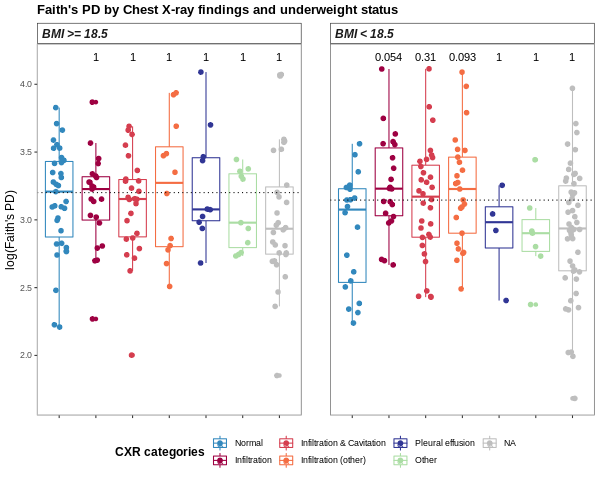

In [26]:
%%R -w 600
cxr_colors <- c("#3288bd","#9e0142","#d53e4f","#f46d43","#313695","#abdda4")

faithpd_means_bybmicat <- summarySE.bootstrap(data=clinical_metadata_table, 
                                              measurevar="faithpd", groupvars="bmi_cat")

faithpd_and_cxr_bybmicat_boxplots <- ggplot(data=clinical_metadata_table, 
                                            aes(y=log(faithpd), x=cxr_categories, colour=cxr_categories)) + 
                                     geom_boxplot() +
                                     geom_jitter(size=2, position=position_jitter(0.2)) + 
                                     #facet_wrap(~ factor(bmi_cat, levels=rev(levels(bmi_cat)))) + 
                                     facet_wrap(~ bmi_cat) + 
                                     scale_colour_manual(name="CXR categories",
                                                         values=cxr_colors, na.value = "grey") + 
                                     scale_fill_manual(values=cxr_colors, na.value = "grey") + 
                                     stat_compare_means(aes(label= ..p.adj..), method = "t.test", 
                                                        ref.group = "Normal", label.y = log(65)) +
                                     geom_hline(aes(yintercept=log(faithpd)), faithpd_means_bybmicat, linetype="dotted") + 
                                     labs(title="Faith's PD by Chest X-ray findings and underweight status", 
                                          x="Chest X-Ray (CXR) categories", y="log(Faith's PD)") + 
                                     theme_bw() + 
                                     theme(axis.text.x=element_blank(), 
                                           plot.title = element_text(face="bold", hjust=0,size=13),
                                           strip.text.x = element_text(angle = 0, hjust = 0,size=12, face = "bold.italic"),
                                           legend.title=element_text(face="bold",size=12),
                                           legend.position="bottom",
                                           axis.title=element_text(size=12), 
                                           axis.title.x=element_blank(),
                                           axis.line = element_line(colour = "grey80"),
                                           panel.spacing = unit(2, "lines"),
                                           strip.background = element_rect(colour="black", fill="white"), 
                                           panel.grid.major = element_blank(), 
                                           panel.grid.minor = element_blank())


faithpd_and_cxr_bybmicat_boxplots

**Number of isolated nodes(genera) by types of CXR findings**

In [27]:
%%R
# Lets obtain a list of the genera that is represented as isolated nodes in the previously
# reconstructed network
genus_nodes_d0 <- names(which(igraph::degree(asv16s_bacteria_genus.ig2) <1))

# Lets obtain the abundance table, aggregated at the genus-level
asv16s_bacteria_genus_counts_ps <- tax_glom(subset_taxa(asv16s_feature_table_ps, Kingdom=="k__Bacteria"), 
                                            "Genus", NArm=FALSE)

In [28]:
%%R
clinical_metadata_table$nrnodesd0 <- colSums(otu_table(asv16s_bacteria_genus_counts_ps)[genus_nodes_d0, 
                                                                                        rownames(clinical_metadata_table)]>0)
# Lets test normality
print(shapiro.test(clinical_metadata_table$nrnodesd0))


	Shapiro-Wilk normality test

data:  clinical_metadata_table$nrnodesd0
W = 0.96085, p-value = 2.417e-07



Lets test if log transformation solves the non-normality:

In [29]:
%%R
print(shapiro.test(log(clinical_metadata_table$nrnodesd0)))


	Shapiro-Wilk normality test

data:  log(clinical_metadata_table$nrnodesd0)
W = 0.9652, p-value = 9.869e-07



Log transformation did not solve the non-normality issue. Therefore we applied a non-parametric test (Wilcoxon test) to compare the Nr. of Isolated nodes across groups of CXR categories:

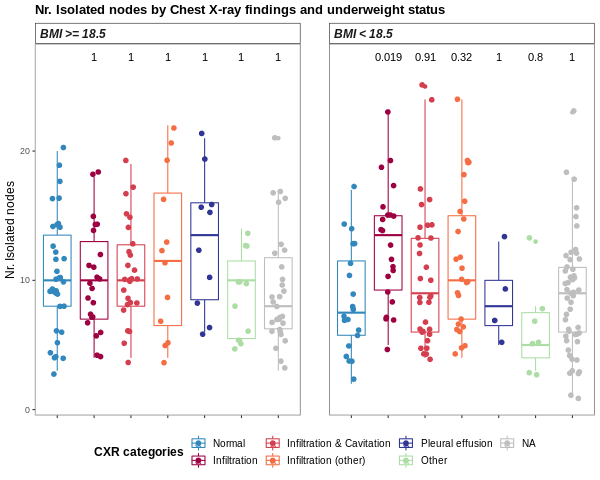

In [30]:
%%R -w 600
nrnodesd0_and_cxr_bybmicat_boxplots <- ggplot(data=clinical_metadata_table, 
                                              aes(y=nrnodesd0, x=cxr_categories, colour=cxr_categories)) + 
                                       geom_boxplot() +
                                       geom_jitter(size=2, position=position_jitter(0.2)) + 
                                       facet_wrap(~ bmi_cat) + 
                                       scale_colour_manual(name="CXR categories",
                                                           values=cxr_colors, na.value = "grey") + 
                                       scale_fill_manual(values=cxr_colors, na.value = "grey") + 
                                       stat_compare_means(aes(label= ..p.adj..), method = "wilcox.test", 
                                                          ref.group = "Normal", label.y = 27) +
                                       #geom_hline(aes(yintercept=log(faithpd)), faithpd_means_bybmicat, linetype="dotted") + 
                                       labs(title="Nr. Isolated nodes by Chest X-ray findings and underweight status", 
                                            x="Chest X-Ray (CXR) categories", y="Nr. Isolated nodes") + 
                                       theme_bw() + 
                                       theme(axis.text.x=element_blank(), 
                                           plot.title = element_text(face="bold", hjust=0,size=13),
                                           strip.text.x = element_text(angle = 0, hjust = 0, size=12, face = "bold.italic"),
                                           legend.title=element_text(face="bold",size=12),
                                           legend.position="bottom",
                                           axis.title=element_text(size=12), 
                                           axis.title.x=element_blank(),
                                           axis.line = element_line(colour = "grey80"),
                                           panel.spacing = unit(2, "lines"), 
                                             strip.background = element_rect(colour="black", fill="white"), 
                                             panel.grid.major = element_blank(),
                                             panel.grid.minor = element_blank(), 
                                             legend.text=element_text(size=10)) + 
                                        guides(fill=guide_legend(override.aes = list(size = 4)))
nrnodesd0_and_cxr_bybmicat_boxplots

### 3.4 Panel with results of associations of Faith's PD, Nr of isolated nodes and CXR findings

[1] 15.27778 15.27778


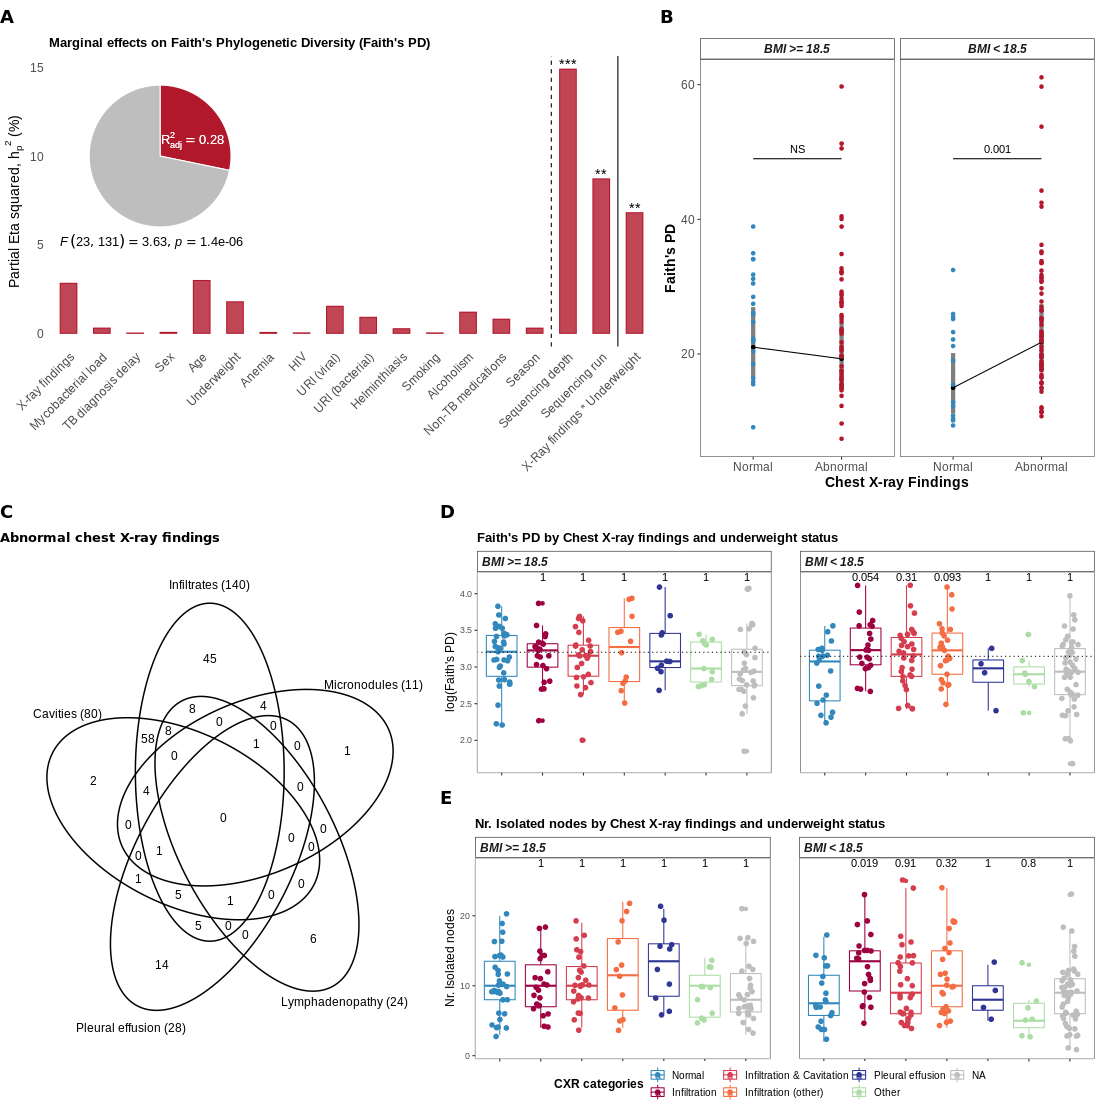

In [31]:
%%R -w 1100 -h 1100
print(par('din'))
faithpd_cxr_panel <- rbind(c(1,1,1,2,2), 
                           c(3,3,3,4,4), 
                           c(5,5,6,6,6),
                           c(7,7,8,8,8),
                           c(7,7,9,9,9),
                           c(7,7,10,10,10),
                           c(NA,NA,11,11,11))

boxplots_legend <- cowplot::get_legend(nrnodesd0_and_cxr_bybmicat_boxplots)
faith_ancova_bycxr_panel <- grid.arrange(grobs=list(textGrob("A",just="left", x=unit(0, "npc"), 
                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                    textGrob("B",just="left", x=unit(0, "npc"), 
                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                    model1_Faith_pes_plot_pie, 
                                                    xrayfindings_faith_bmi_plot, 
                                                    textGrob("C",just="left", x=unit(0, "npc"), 
                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                    textGrob("D",just="left", x=unit(0, "npc"), 
                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                    cxr_findings_venn_gg,
                                                    faithpd_and_cxr_bybmicat_boxplots + theme(legend.position="none"),
                                                    textGrob("E",just="left", x=unit(0, "npc"), 
                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")), 
                                                    nrnodesd0_and_cxr_bybmicat_boxplots + theme(legend.position="none"),
                                                    boxplots_legend
                                                   ),
                                         layout_matrix=faithpd_cxr_panel,
                                         widths=c(0.2,0.2,0.2,0.2,0.2), 
                                         heights=c(0.03,0.42,0.03,0.23,0.03,0.23,0.03))

faith_ancova_bycxr_panel_file <- "./reports/figures/asv16s_faithpd_ancova_cxrs.svg"
ggsave(faith_ancova_bycxr_panel_file, faith_ancova_bycxr_panel, width=15.28, height=15.28)

### 3.5 ANCOVA model to assess the marginal effects of TB score on Faith's phylogenetic diversity

**Model selection**

In [33]:
%%R
# Model without interactions
model2_Faith_fit_nointer <- lm(log(faithpd) ~ tbscore_bin + tbdelay + 
                               male + age_cat + 
                               hiv + viral + bacterial + helminth + smoking + alcoholabuse + 
                               delaymed_3cat + season + seq_depth_sc + seq_run, 
                               data=clinical_metadata_table, 
                               contrasts=model_contrasts)

# Model with interactions (full model)
model2_Faith_fit_full <-  lm(`log(faithpd)` ~ tbscore_bin + tbdelay + 
                             male + age_cat + 
                             hiv + viral + bacterial + helminth + smoking + alcoholabuse + 
                             delaymed_3cat + season + seq_depth_sc + seq_run + 
                             tbscore_bin*tbdelay +
                             tbscore_bin*male +
                             tbscore_bin*age_cat + 
                             tbscore_bin*hiv + 
                             tbscore_bin*viral + 
                             tbscore_bin*bacterial + 
                             tbscore_bin*helminth + 
                             tbscore_bin*smoking + 
                             tbscore_bin*alcoholabuse + 
                             tbscore_bin*season , 
                             data=model2_Faith_fit_nointer$model, 
                             contrasts=model_contrasts)

model2_Faith_fit_null <- lm(`log(faithpd)` ~ 1, data=model2_Faith_fit_nointer$model, 
                            contrasts=model_contrasts)

# Step forward selection of interaction terms
model2_Faith_fwd_aic_selected <- my_model_selector(model2_Faith_fit_null, model2_Faith_fit_nointer, 
                                                   model2_Faith_fit_full)

#print(Anova(nonhiv_Faith_fit_nointer, type=2))
print(car::Anova(model2_Faith_fwd_aic_selected, type=3))


Step-Forward addition of interaction terms:
Start:  AIC=-328.12
log(faithpd) ~ tbscore_bin + tbdelay + male + age_cat + hiv + 
    viral + bacterial + helminth + smoking + alcoholabuse + delaymed_3cat + 
    season + seq_depth_sc + seq_run

                           Df Sum of Sq    RSS     AIC
<none>                                  28.358 -328.12
+ tbscore_bin:viral         1   0.12339 28.234 -323.69
+ tbscore_bin:hiv           1   0.10905 28.248 -323.58
+ tbscore_bin:tbdelay       1   0.10042 28.257 -323.51
+ tbscore_bin:smoking       1   0.09814 28.259 -323.50
+ tbscore_bin:bacterial     1   0.06006 28.297 -323.21
+ tbscore_bin:alcoholabuse  1   0.03064 28.327 -322.98
+ tbscore_bin:male          1   0.00441 28.353 -322.79
+ tbscore_bin:helminth      1   0.00021 28.357 -322.75
+ tbscore_bin:season        2   0.47008 27.887 -320.98
+ tbscore_bin:age_cat       3   0.54270 27.815 -316.17

Is the model without interactions better than a null model?
Analysis of Variance Table

Model 1: 

### 3.6 ANCOVA model to assess the marginal effects of _MTB_ lineage on Faith's phylogenetic diversity

**Model selection**

In [34]:
%%R
# Model without interactions
model3_Faith_fit_nointer <- lm(log(faithpd) ~ islineage3 + xray_findings*bmi_cat + smear_grading_bin + tbdelay + 
                               male + age_cat + anemia_bin +
                               hiv + viral + bacterial + helminth + smoking + alcoholabuse + 
                               delaymed_3cat + season + seq_depth_sc + seq_run, 
                               data=clinical_metadata_table, 
                               contrasts=model_contrasts)

# Model with interactions (full model)
model3_Faith_fit_full <-  lm(`log(faithpd)` ~ islineage3 + xray_findings*bmi_cat + smear_grading_bin + tbdelay + 
                             male + age_cat + anemia_bin +
                             hiv + viral + bacterial + helminth + smoking + alcoholabuse + 
                             delaymed_3cat + season + seq_depth_sc + seq_run + 
                             islineage3*tbdelay +
                             islineage3*male +
                             islineage3*age_cat + 
                             islineage3*bmi_cat + 
                             islineage3*anemia_bin +
                             islineage3*hiv + 
                             islineage3*viral + 
                             islineage3*bacterial + 
                             islineage3*helminth + 
                             islineage3*smoking + 
                             islineage3*alcoholabuse + 
                             islineage3*season , 
                             data=model3_Faith_fit_nointer$model, 
                             contrasts=model_contrasts)

model3_Faith_fit_null <- lm(`log(faithpd)` ~ 1, data=model3_Faith_fit_nointer$model, 
                            contrasts=model_contrasts)

# Step forward selection of interaction terms
model3_Faith_fwd_aic_selected <- my_model_selector(model3_Faith_fit_null, model3_Faith_fit_nointer, 
                                                   model3_Faith_fit_full)

#print(Anova(nonhiv_Faith_fit_nointer, type=2))
print(car::Anova(model3_Faith_fwd_aic_selected, type=3))


Step-Forward addition of interaction terms:
Start:  AIC=-137.43
log(faithpd) ~ islineage3 + xray_findings * bmi_cat + smear_grading_bin + 
    tbdelay + male + age_cat + anemia_bin + hiv + viral + bacterial + 
    helminth + smoking + alcoholabuse + delaymed_3cat + season + 
    seq_depth_sc + seq_run

                          Df Sum of Sq    RSS     AIC
<none>                                 9.0836 -137.43
+ islineage3:alcoholabuse  1   0.32494 8.7586 -136.58
+ islineage3:tbdelay       1   0.30143 8.7821 -136.30
+ islineage3:bmi_cat       1   0.26091 8.8226 -135.82
+ islineage3:hiv           1   0.17184 8.9117 -134.78
+ islineage3:bacterial     1   0.16682 8.9167 -134.72
+ islineage3:smoking       1   0.10500 8.9786 -134.00
+ islineage3:viral         1   0.06803 9.0155 -133.57
+ islineage3:male          1   0.05484 9.0287 -133.42
+ islineage3:season        2   0.43671 8.6468 -133.27
+ islineage3:helminth      1   0.03133 9.0522 -133.15
+ islineage3:anemia_bin    1   0.02625 9.0573 -

**Diagnostics of selected model**


Homoscedascity test
Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.302634, Df = 1, p = 0.58224

Multicolinearity test
                          GVIF Df GVIF^(1/(2*Df))
islineage3            1.218486  1        1.103851
xray_findings         1.403977  1        1.184895
bmi_cat               2.365211  1        1.537924
smear_grading_bin     1.490449  1        1.220839
tbdelay               1.394099  1        1.180720
male                  1.453504  1        1.205613
age_cat               2.464266  3        1.162201
anemia_bin            1.275198  1        1.129247
hiv                   1.565146  1        1.251058
viral                 1.410873  1        1.187802
bacterial             1.280096  1        1.131413
helminth              1.457502  1        1.207271
smoking               1.690767  1        1.300295
alcoholabuse          1.838869  1        1.356049
delaymed_3cat         1.586511  2        1.122305
season                2.535598  2        1.26

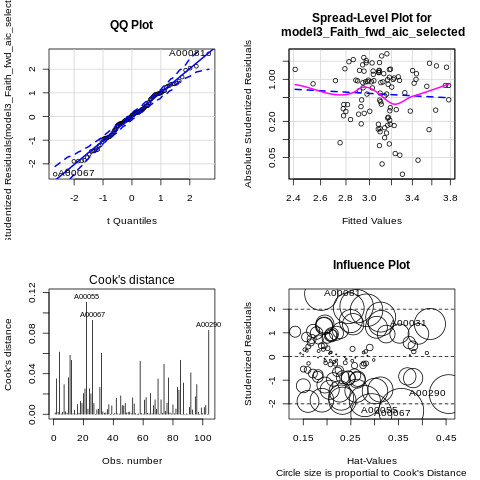

In [35]:
%%R
library(car)
par(mfrow=c(2,2))

# Normality of residuals
#------------------------
qqPlot(model3_Faith_fwd_aic_selected, main= "QQ Plot")

# Homoscedascity
#------------------------
# Score Test for Non-Constant Error Variance
# null hypothesis : constant error variance
# alternative hypothesis: the error variance changes with the level of the response (fitted values)
cat(crayon::bold("\nHomoscedascity test\n"))
print(ncvTest(model3_Faith_fwd_aic_selected))

# Plot studentized residuals vs. fitted values
spreadLevelPlot(model3_Faith_fwd_aic_selected, robust.line=TRUE)

# Non-Multicolinearity
#--------------------------
cat(crayon::bold("\nMulticolinearity test\n"))
# Generalized variance-inflation factors (GVIF)
# GVIF^(1/(2*Df)) : GVIF adjusted for the dimension of the confidence ellipsoid
# where df is the degrees of freedom associated with the term
print(car::vif(model3_Faith_fwd_aic_selected))

# Independence of errors
#--------------------------
cat(crayon::bold("\nDurbin-Watson Test for Autocorrelated Errors\n"))
# Durbin-Watson Test for Autocorrelated Errors
# null hypothesis: no autocorrelation of errors
# alternative hypothesis: autocorrelation of errors
print(durbinWatsonTest(model3_Faith_fwd_aic_selected))

# Influential observations
#----------------------------
cat(crayon::bold("\nInfluential observations\n"))
# Cook's D plot
# identify D values > 4/(n-k-1)
model3_Faith_cooks_cutoff <- 4/((nrow(model3_Faith_fwd_aic_selected$model)-length(model3_Faith_fwd_aic_selected$coefficients)-2))
plot(model3_Faith_fwd_aic_selected, which=4, cook.levels=model3_Faith_cooks_cutoff)

# Influence plot 
model3_Faith_influencers <- influencePlot(model3_Faith_fwd_aic_selected, id.method="identify", 
                                   main="Influence Plot", 
                                   sub="Circle size is proportial to Cook's Distance" )
print(row.names(model3_Faith_influencers))

# Effect of removing influential observations
# -------------------------------------------
cat(crayon::bold("\nEffect of influential observations"))
# Vector flagging influential observations
model3_is_influencer <- (row.names(model3_Faith_fwd_aic_selected$model) %in% row.names(model3_Faith_influencers))
# Re-fit model after removing influential observations
model3_Faith_fwd_aic_selected_updated <- update(model3_Faith_fwd_aic_selected, subset=!model3_is_influencer)

cat("\nAdjusted R-squared of model (with influential observations): ")
cat(summary(model3_Faith_fwd_aic_selected)$adj.r.squared)
cat("\nP-value of model: ")
cat(pf(summary(model3_Faith_fwd_aic_selected)$fstatistic[1], 
       summary(model3_Faith_fwd_aic_selected)$fstatistic[2], 
       summary(model3_Faith_fwd_aic_selected)$fstatistic[3], 
       lower.tail = FALSE)[1])
cat("\nAdjusted R-squared of model (removed influential observations): ")
cat(summary(model3_Faith_fwd_aic_selected_updated)$adj.r.squared)
cat("\nP-value of updated model: ")
cat(pf(summary(model3_Faith_fwd_aic_selected_updated)$fstatistic[1], 
       summary(model3_Faith_fwd_aic_selected_updated)$fstatistic[2], 
       summary(model3_Faith_fwd_aic_selected_updated)$fstatistic[3], 
       lower.tail = FALSE)[1])

**Effect size of factors within model**

In [36]:
%%R
model3_Faith_covars <- c('islineage3','xray_findings','smear_grading_bin','tbdelay', 'male','age_cat',
                         'bmi_cat','anemia_bin','hiv','viral','bacterial','helminth','smoking',
                         'alcoholabuse','delaymed_3cat','season','seq_depth_sc','seq_run')
model3_Faith_interactions <- c("xray_findings*bmi_cat")

model3_Faith_w_pes <- Anova.combined(response=log(clinical_metadata_table[rownames(model3_Faith_fwd_aic_selected$model),
                                                                           'faithpd']),
                                     vars=model3_Faith_covars,
                                     inter.formula=model3_Faith_interactions,
                                     data=model3_Faith_fwd_aic_selected$model[model3_Faith_covars], 
                                     contrasts=model_contrasts, type=3)
model3_Faith_w_pes

y.data ~ . + xray_findings * bmi_cat
<environment: 0x55fbf6231640>
                                  Row.names       Sum Sq Df      F value       Pr(>F)          pes   Pr(>F).uni      pes.uni
(Intercept)                     (Intercept) 5.349886e+01  1 4.652816e+02 7.518604e-35 8.548545e-01           NA           NA
islineage3                       islineage3 5.270913e-04  1 4.584133e-03 9.461906e-01 5.802364e-05 9.544200e-01 3.218570e-05
xray_findings                 xray_findings 9.127588e-02  1 7.938297e-01 3.756501e-01 9.948510e-03 8.380727e-01 4.113661e-04
smear_grading_bin         smear_grading_bin 2.117703e-03  1 1.841774e-02 8.923942e-01 2.330817e-04 2.329394e-01 1.391991e-02
tbdelay                             tbdelay 1.457249e-02  1 1.267375e-01 7.227880e-01 1.601702e-03 9.940825e-01 5.419122e-07
male                                   male 5.974138e-02  1 5.195730e-01 4.731515e-01 6.533901e-03 2.927626e-01 1.084573e-02
age_cat                             age_cat 3.723753e-01  

Lets plot the effect sizes:

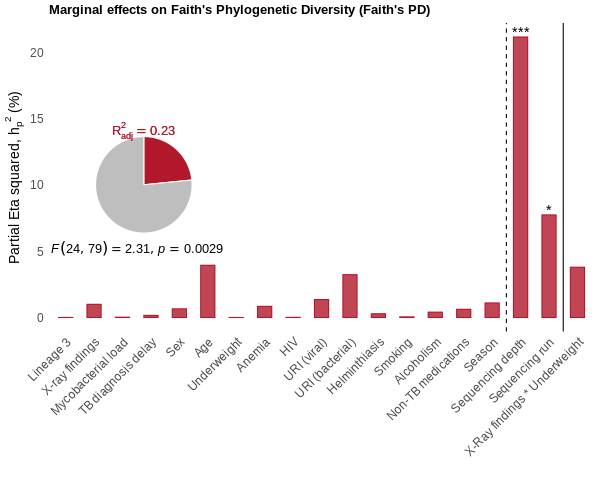

In [37]:
%%R -w 600

model3_Faith_w_pes_toplot <- model3_Faith_w_pes[2:(dim(model3_Faith_w_pes)[1]-1),]
model3_Faith_w_pes_toplot$Row.names <- factor(model3_Faith_w_pes_toplot$Row.names, 
                                              levels=c(model3_Faith_covars,
                                                       'xray_findings:bmi_cat'))
var_labels <- c('islineage3'='Lineage 3',
                'xray_findings'='X-ray findings',
                'smear_grading_bin'='Mycobacterial load',
                'tbdelay'='TB diagnosis delay',
                'male'='Sex', 
                'age_cat'='Age',
                'bmi_cat'='Underweight', 
                'anemia_bin'='Anemia', 
                'hiv'='HIV',
                'viral'='URI (viral)', 
                'bacterial'='URI (bacterial)', 
                'helminth'='Helminthiasis', 
                'smoking'='Smoking',
                'alcoholabuse'='Alcoholism',
                'delaymed_3cat'='Non-TB medications',
                'season'='Season', 
                'seq_depth_sc'='Sequencing depth',
                'seq_run'='Sequencing run', 
                'xray_findings:bmi_cat'='X-Ray findings * Underweight')

signif_marks <- rep("",length(var_labels))
signif_marks[ model3_Faith_w_pes_toplot[,'Pr(>F)'] < 0.001 ] <- '***'
signif_marks[ model3_Faith_w_pes_toplot[,'Pr(>F)'] < 0.01 & model3_Faith_w_pes_toplot[,'Pr(>F)'] >= 0.001 ] <- '**'
signif_marks[ model3_Faith_w_pes_toplot[,'Pr(>F)'] < 0.05 & model3_Faith_w_pes_toplot[,'Pr(>F)'] >= 0.01 ] <- '*'

model3_Faith_pes_plot <- ggplot(model3_Faith_w_pes_toplot, aes(x=Row.names,y=pes*100)) + 
                            geom_bar(position='identity', stat='identity',
                                     fill="#b2182b", color="#b2182b", alpha=0.8, width=0.5) + 
                            theme_minimal() + 
                            theme(axis.text.x = element_text(size=12,angle=45, hjust=1), 
                                  axis.text.y = element_text(size=12),
                                  axis.title=element_text(size=14,face="bold"), 
                                  plot.title = element_text(face="bold", hjust=0,size=13),
                                  panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
                            scale_x_discrete(labels=var_labels) + 
                            ggtitle("Marginal effects on Faith's Phylogenetic Diversity (Faith's PD)") + 
                            labs(x='', y=bquote('Partial Eta squared,' ~ {h[p]}^2 ~ '(%)')) + 
                            geom_text(aes(label=signif_marks), size=5, vjust=0) + 
                            geom_vline(xintercept=c(16.5,18.5), linetype = c("dashed","solid"))

model3_Faith_pie_data <- data.frame(Radj=c(summary(model3_Faith_fwd_aic_selected)$adj.r.squared, 
                                           (1-summary(model3_Faith_fwd_aic_selected)$adj.r.squared)), 
                                    group=c('Radj','FVU'))
model3_Faith_pie_label <- bquote(R[adj]^2 == .(signif(model3_Faith_pie_data$Radj[1], 2)))

model3_Faith_pie <- ggplot(model3_Faith_pie_data, aes(x="",y=Radj, fill=group)) + 
                        geom_bar(stat="identity", width=1, color="white") + 
                        coord_polar("y", start=0) +
                        scale_fill_manual(values = c("grey","#b2182b")) + 
                        theme_void() + theme(legend.position="none") + 
                        geom_text(aes(x=1.6,y=1, size=3, label=deparse(model3_Faith_pie_label)), 
                                  color="#b2182b", parse=TRUE)
model3_Faith_pie_grob <- ggplotGrob(model3_Faith_pie)

model3_Faith_model_fstats_label <- paste0('list(italic(F)(', summary(model3_Faith_fwd_aic_selected)$fstatistic[2], 
                                          ',', summary(model3_Faith_fwd_aic_selected)$fstatistic[3], ') == ', 
                                          signif(summary(model3_Faith_fwd_aic_selected)$fstatistic[1],3),
                                          ' , italic(p) == ',signif(pf(summary(model3_Faith_fwd_aic_selected)$fstatistic[1], 
                                                                    summary(model3_Faith_fwd_aic_selected)$fstatistic[2], 
                                                                    summary(model3_Faith_fwd_aic_selected)$fstatistic[3],
                                                                    lower.tail=FALSE), 2), ')')
model3_Faith_pes_plot_pie <- model3_Faith_pes_plot + annotate('text', x=3.5, y=5.2, size=4.5,
                                                              label=model3_Faith_model_fstats_label, parse=TRUE) + 
                             annotation_custom(grob=model3_Faith_pie_grob, xmin=0.5, xmax=7, ymin=5, ymax=15)

plot(model3_Faith_pes_plot_pie)

Lets plot the adjusted means for the significant interaction term:

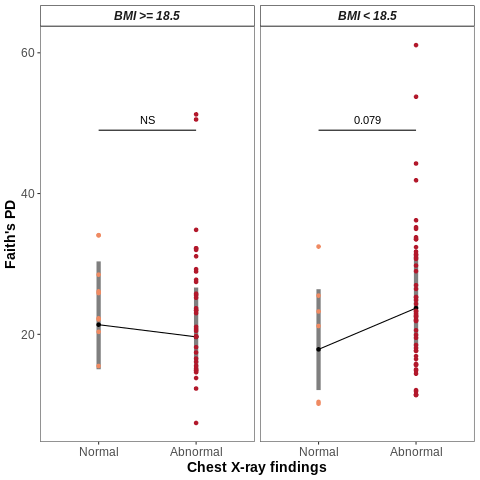

In [38]:
%%R
reformat_pval <- function(x){
    if(x<0.1){
        formatC(x, digits=3, format='f')
    }else{
        'NS'}
}

islineage3_colors <- c('#ef8a62','#b2182b')

# For correct interpretation of log transformation by emmeans, we refit the model
islineage3_faith_lm <- lm(log(faithpd) ~ islineage3 + xray_findings + smear_grading_bin + tbdelay + 
                          male + age_cat + bmi_cat + anemia_bin + 
                          hiv + viral + bacterial + helminth + smoking + alcoholabuse + delaymed_3cat + 
                          season + seq_depth_sc + seq_run + xray_findings*bmi_cat, 
                          data = clinical_metadata_table, contrasts = model_contrasts)

# Estimated differene in PD means among levels of Chest X-ray findings, within BMI categories
islineage3_faith_cxr_bmi_contrasts_df <- as.data.frame(pairs(emmeans(islineage3_faith_lm, ~ xray_findings | bmi_cat)))
islineage3_faith_cxr_bmi_contrasts_df$x_start <- c(1,1)
islineage3_faith_cxr_bmi_contrasts_df$x_end <- c(2,2)
islineage3_faith_cxr_bmi_contrasts_df$y_end <- c(50,50)
islineage3_faith_cxr_bmi_contrasts_df$p_reformat <- sapply(islineage3_faith_cxr_bmi_contrasts_df$p.value,reformat_pval)
islineage3_faith_cxr_bmi_plot <- emmip(islineage3_faith_lm, ~ xray_findings | bmi_cat, CIs=TRUE, 
                                       type = "response") +  facet_wrap(~ bmi_cat, scales="free_x") +
                                 geom_point(aes(x=xray_findings, y=exp(`log(faithpd)`), color=xray_findings), 
                                            data=islineage3_faith_lm$model) + 
                                 scale_color_manual(values=islineage3_colors) +
                                 geom_text(aes(x=(x_start+x_end)/2, y=y_end+0.5,label=p_reformat), 
                                           data=islineage3_faith_cxr_bmi_contrasts_df) +
                                 geom_segment(aes(x=x_start, xend=x_end, y=y_end-1, yend=y_end-1), 
                                              data=islineage3_faith_cxr_bmi_contrasts_df) + 
                                 labs(y="Faith's PD", x="Chest X-ray findings") + 
                                 theme_bw() + 
                                 theme(axis.text.x = element_text(size=12), 
                                   axis.text.y = element_text(size=12),
                                   axis.title=element_text(size=14,face="bold"), 
                                   strip.text.x = element_text(size = 12, face = "bold.italic"),
                                   strip.background = element_rect(colour="black", fill="white"),
                                   legend.position="none", 
                                   panel.grid.major = element_blank(),
                                   panel.grid.minor = element_blank())

plot(islineage3_faith_cxr_bmi_plot)

[1] 15.277778  6.944444


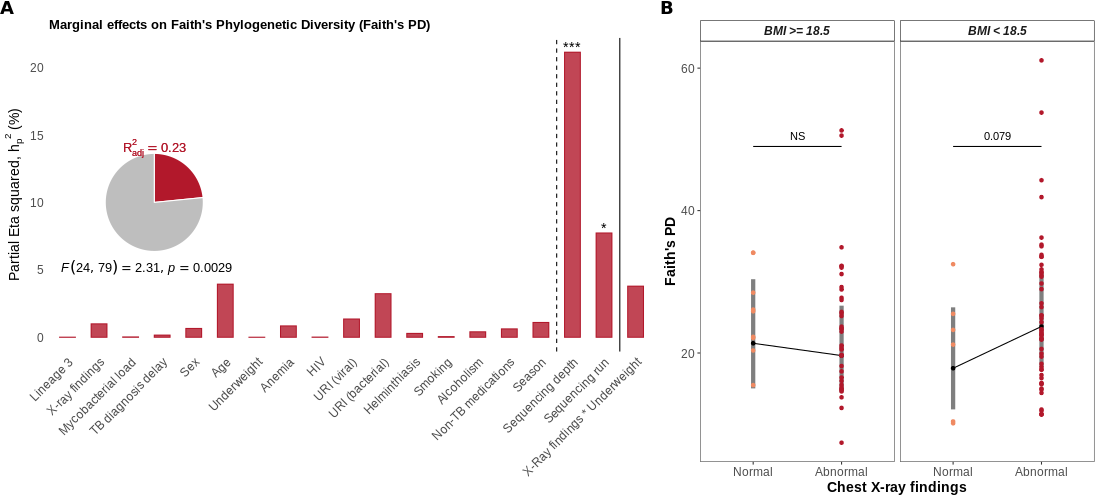

In [39]:
%%R -w 1100 -h 500
print(par('din'))

panel_layout <- rbind(c(1,1,1,2,2),
                      c(3,3,3,4,4))

faithpd_lineage3_hiv_panel <- grid.arrange(grobs=list(textGrob("A",just="left", x=unit(0, "npc"), 
                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                      textGrob("B",just="left", x=unit(0, "npc"), 
                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                      model3_Faith_pes_plot_pie, 
                                                      islineage3_faith_cxr_bmi_plot), 
                                           layout_matrix=panel_layout,
                                           widths=c(0.2,0.2,0.2,0.2,0.2), 
                                           heights=c(0.03,0.97))

faithpd_lineage3_hiv_panel_file <- "./reports/figures/asv16s_faithpd_ancova_lineage.svg"
ggsave(faithpd_lineage3_hiv_panel_file, faithpd_lineage3_hiv_panel, width=15.28, height=6.94)